# Daten laden und vorverarbeiten

In [1]:
import pandas as pd
import re
import requests
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('punkt')

import spacy

from gensim import models
from gensim.models import Phrases, Word2Vec
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

from sklearn.model_selection import ParameterGrid
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pyLDAvis.gensim_models
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import warnings, logging
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path, encoding='utf-8')
    return df

def preprocess_text(text):
    email = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    text = email.sub('', text)
    
    url= re.compile(r'http?s//:\S+')
    text = url.sub('', text)
    
    text = re.sub(r'[^\w\s\d+]', ' ', text)
    
    text = text.strip()
    text = text.lower()
    return text

def tokenize_text(text):
    return word_tokenize(text, language='german')

def make_bigrams(texts):
    bigram = Phrases(texts, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)
    return [bigram_mod[text] for text in texts]

def make_trigrams(texts):
    bigram = Phrases(texts, min_count=7, threshold=100)
    bigram_mod = Phraser(bigram)
    trigram = Phrases(bigram[texts], threshold=100)
    trigram_mod = Phraser(trigram)
    return [trigram_mod[bigram_mod[text]] for text in texts]

def lemmatize(texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for text in texts:
        word_list = nlp(" ".join(text))
        texts_out.append([word.lemma_.lower() for word in word_list if word.pos_ in allowed_postags])
    return texts_out

def remove_stopwords(texts, stop_words):
    return [[word for word in text if word.lower() not in stop_words] for text in texts]

In [3]:
# Laden der Daten
url = "https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen"
response = requests.get(url).json()
df = pd.json_normalize(response, record_path=['index'])
df.replace(to_replace=[None], value='', inplace=True)

# Bereinigung
df['sachverhalt_clean'] = df['sachverhalt'].map(preprocess_text)
data = df['sachverhalt_clean'].values.tolist()

# Tokenisierung
data_tokenized = [tokenize_text(word) for word in data]

# Laden der Stoppwörter
stop_words = stopwords.words('german')
custom_stopwords = ['komplett', 'seit', 'vier', 'tag', 'kz', 'hinein', 'darauf', 'sowie', 'einzeln', 'seit', 'woche', 'drumherum', 'hallo', 'mitteilen', 'gottlieb', 'moment', 'bluten', 'herz', 'fallen', 'kein_möglichkeit', 
                    'vielleicht', 'mit_freundlich_grüße', 'zeitweise', 'rund_um', 'regelmäßig', 'daneben', 'sodass', 'unschön', 'woche', 'diverse', 'zahlreich', 'extratische', 'tante', 'lisbeth', 'öffnen', 'tag', 
                    'herrenlose', 'gebet', 'bitte', 'helfen', 'heute_morgen', 'alt', 'eigentlich', 'dagegen', 'entlich_mal', 'leern', 'woche', 'destages', 'schön_wenn', 'meldung', 'wegen', 'lang', 'schwarz', 'vieler', 
                    'monat', 'insbesondere', 'seite', 'natürlich', 'erklärung', 'leid', 'kontinuierlich', 'wem', 'inzwischen', 'dadurch', 'bevor', 'u_bhf', 'ost', 'sin', 'genau', 'eher', 'ok', 'gesamt', 'gut_tag', 
                    'einiger_zeit', 'ab', 'nr', 'irgendwann', 'ange', 'bsr', 'zwei', 'weit', 'etwa', 'los', 'z_--', 'oft', 'ca_m', 'n', 'e', 'n', 'grad', 'h', 'quasi', 'aller_art', 'usw', 'ab', 'lt', 'bsr', '°', 'pa', 
                    'gut_tag', 'fraenkelufer', 'so_nah', 'wieso', 'ich_glauben', 'paar', 'wir_bitten', 'um_prüfung', 'herzlich_dank', 'ps', 'lassen', 'wissen', 'sollen', 'totaler', 'unmeng', 'gut_tag', 'wieder_einmal', 
                    'nähe', 'kieferorthopädie', 'mittlerweile', 'fast', 'gute_grüße', 'hinaus', 'leider', 'nah', 'meist', 'gerne', 'soo', 'zb', 'oä', 'vor_ort', 'klar', 'je', 'wann', 'irgendwann', 'genug', 'meh', 'kvz', 
                    'danke', 'vüd', 'ord', '￼', 'modellvielfältigkeit', 'mehrere', 'ihr_fahrräder_aller_art', 'ausgangspunkt', 'herr_anbei', 'v_nachgang_mein_mitteilung', 'lt_img_jpeg_gt', 'lt_jpeg_gt_lt', 'um_schreiben_k', 
                    'jpeg_gt', 'groß', 'fahrzeug_werden_nicht_ordnungsgemäß_parken_weder', 'div', 'de', 'y', 'z', 'kx', 'vl', 'bisher', 'deutlich', 'weit', 'rund_um', 'sich_hierbei', 'ich_glauben',  'teil', 'i', 'te', 
                    'cm', 'a', 'aod', 'lg', 'gesntworten', 'viele_dank', 'sehen', 'bild', 'sehen_bild', 'kubikmeter', 'ihr_freundlich', 'uhr_topf_aufeinander_knallen', '--_foto', 'art_modellvielfältigkeit', 'leut', 
                    'o', 'sehr_geehrt', 'vieler_dank', '--', 'wer', 'generell', 'ebenfalls', 'gar', 'team', 'bahcesi', 'merhaba', 'frühsn', 'seir', 'x', 'dba', 'mfg', 'bzw', 'sehr_geehrt_dame', 'u', 'teilweise', 'wdh', 
                    'ca_m³', 'xxd', 'gut', 'sehen_foto', 'herum', 'manfred_von', 'grüße_r', 'Scherzh', 'k', 'd', 'g', 'str', 'm', 'x', 'oa', 'vg', 'f', 's', 'qm', 'ca', 'siehe_Foto', 'bild', 'art', 'siehe_bild', 'direkt', 
                    'foto', 'ganz', 'diverser', 'Paragraphenzeichen', 'Summenfolg', 'Eiskast', 'Pott', 'zuzuordn', 'Modellvielfältigkeit', 'K_V', 'gemäß', 'Scherzhaft', 'fig', 'scherzhaft', 'kommentierend', 'durch_Bodenwisch', 
                    'ihren_Fahrräder', 'Sehr_geehrte_Damen', 'Mit_freundlich', 'Grüßen_K_', 'Meldungsnummer_qq', 'PB', 'ja', 'Hauptform', 'durch_bodenwisch', 'her', 'nsch', 'sehr_geehrte_damen', 'übersende_ich', 'ihren_fahrräder', 
                    'paragraphenzeiche', 'ihre_freundlich', 'mehr', 'k_v', 'scherzh', 'gt_lt', 'mehr_benutzung', 'leutselig_grüß', 'pb', 'so_dassen', 'bild', 'gab_es', 'siehe_bild', 'foto', 'ggü', 'etc', 'zmr', 'meldungsnr', 
                    'lagetsi', 'ich_möchn', 'tun', 'hab_ich', 'gerade', 'dennoch', 'gleich', 'immer', 'bereits', 'rum', 'völlig', 'weidl', 'stefanie', 'pöthig', 'hierüber', 'geehrt', 'damen', 'und', 'herren', 'schon', 
                    'herr', 'häufig', 'dame', 'ich_möchten', 'immerhin', 'grüßenk', 'geehrte_damen', 'vsehr', 'mal', 'seeehr', 'grüßenstefanie', 'lieb', 'berlintel', 'mit_freundlich', 'auf_dem', 'u_a', 
                    'hiermit', 'soweit', 'zudem', 'siehe_foto', 'nicht_mehr', 'mehr_als', 'freundlich_grüße', 'sehr_geehrt_dame_und_herr', 'anbei_übersenden', 'gt_schreiben', 'gt', 'schreiben', 'nachgang_mitteilung', 
                    'genehmigungsfähig_sondernutzung', 'pfo', 'meldungsnummer', 'bemühung', 'v', 'nachgang', '§', 'freundlich', 'mitteilung', 'übersend', 'grüßen', 'phänom', 'sache', 'sonstig','speisere', 
                    'blau', 'gelb', 'säck', 'passier', 'anzeig', 'tret', 'höhe', 'ecke', 'funktion',  'geehrte', 'jahr', 'essensre', 'situation', 'säcken', 'rechter', 'zeit', 'teilbereich', 'bügel', 'unbekannt', 'besitzer', 
                    'sine', 'weiß', 'firma', 'antwort', 'scher', 'kollege', 'matratz', 'ort', 'stelle', 'richtung', 'dritter', 'östlich', 'teller', 'letzter', 'verschieden', 'mülltonn', 'maßnahme', 'fahrzeug_feuerwehr_müllabfuhr',
                    'klein', 'menge', 'meter', 'bereich', 'hausnummer', 'verständnis', 'derzeitig', 'aktuell', 'müsste', 'fotos', 'fall', 'herse', 'gucken', 'kettinger', 'föttinger', 'ketting', 'ostseite', 'minute', 'video',
                    'entsprechend', 'erkenn', 'rot', 'verbreit', 'ä', 'allfällig', 'geben', 'entlich', 'unverändert', 'freundlichen', 'scheinen', 'ki', 'nutzen', 'kommen', 'knallen_uhr', 'uhr_geräusch', 'töpfe_knallen', 
                    'uhr_geräusch_bodenwisch_uhr', 'wand', 'uhr_maschine', 'uhr_töpfe', 'dortig', 'etc', 'bzw', 'eigen', 'wirkt', 'inwieweit', 'südster', 'mitlerweil', 'bsc', 'bsp', 'gewiß', 'übrig', 'wiener', 'zweiter', 
                    'wesentlich', 'k5', 'besonders']

stop_words.extend(custom_stopwords)
stop_words = [word.lower() for word in stop_words]

# Entfernen von Stoppwörtern
data_without_stopwords = remove_stopwords(data_tokenized, stop_words)

# Lemmatisierung und Entfernen von Stoppwörtern
#!python -m spacy download de_core_news_sm
nlp = spacy.load("de_core_news_sm")
data_lemmatized = lemmatize(data_without_stopwords, nlp, allowed_postags=['NOUN', 'ADJ'])

# Entfernen von Stoppwörtern
data_without_stopwords = remove_stopwords(data_lemmatized, stop_words)

# Anwenden von Bigrammen
# words_bigram = make_bigrams(words_tokenized)
# Anwenden von Trigrammen
data_trigram = make_trigrams(data_without_stopwords)

# Entfernen von Stoppwörtern
data_without_stopwords = remove_stopwords(data_trigram, stop_words)

# entferne leere Listenelemente
data_ready = [words for words in data_without_stopwords if words]

In [4]:
# Aufbau des Wörterbuchs und des Bag-of-Words-Korpus
id2word = Dictionary(data_ready)
print(f"Vokabular vor der Filterung: {len(id2word)}")
id2word.filter_extremes(no_below=5, no_above=0.6, keep_n=1000) 
print(f"Vokabular nach der Filterung: {len(id2word)}")

bow_corpus = [id2word.doc2bow(text, allow_update=True) for text in data_ready]

Vokabular vor der Filterung: 4289
Vokabular nach der Filterung: 450


# Finden des besten Models mithilfe von Grid Search

In [5]:
def grid_search_lda(corpus, dictionary, texts, num_topics):
    # Parameter-Grid für die Grid-Suche
    param_grid = {
        'num_topics': num_topics,
        'decay': [0.5, 0.7, 1.0],
        'chunksize': [50],
        'passes': [50],
        'alpha': [0.05, 0.07, 0.1],
        'eta': [0.007, 0.01, 0.03, 0.05],
    }

    best_model = None
    best_coherence = -np.inf
    best_perplexity = np.inf

    # Durchlaufe alle Kombinationen der Parameter im Parameter-Grid
    for params in ParameterGrid(param_grid):
        # Erstelle das Modell
        model = models.LdaModel(corpus=corpus, id2word=dictionary, **params)

        # Berechne die Kohärenz für das aktuelle Modell
        coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_score = coherence_model.get_coherence()
        
        # Berechne die Perplexität
        perplexity = model.log_perplexity(model[corpus])
        
        # Ausgabe der Modellparameter
        print(f"Model Parameters: {params}")

        # Aktualisiere das beste Modell, falls das aktuelle Modell eine bessere Kohärenz aufweist
        if (abs(coherence_score) < abs(best_coherence)):
            best_model = model
            best_coherence = coherence_score
            best_perplexity = perplexity

    return best_model, best_coherence, best_perplexity

def grid_search_lda_tfidf(corpus, dictionary, texts, num_topics):
    # Parameter-Grid für die Grid-Suche von TF-IDF und LDA
    param_grid = {
        'num_topics': num_topics,
        'decay': [0.5, 0.7, 1.0],
        'chunksize': [50],
        'passes': [50],
        'alpha': [0.05, 0.07, 0.1],
        'eta': [0.001, 0.003, 0.005, 0.007, 0.01], 
    }

    smartirs_options = ['nfc', 'ntc'] 
    
    best_model = None
    best_corpus = None
    best_coherence = -np.inf
    best_perplexity = np.inf
    
    # Durchlaufe alle Kombinationen der Parameter im kombinierten Parameter-Grid
    for smartirs in smartirs_options:
        # Erstelle das TF-IDF-Modell
        tfidf_model = models.TfidfModel(corpus, dictionary=dictionary, smartirs=smartirs)
        tfidf_corpus = tfidf_model[corpus]
        
        print(f'TF-IDF Smartirs: {smartirs}')
        for params in ParameterGrid(param_grid):
            # Erstelle das LDA-Modell
            model = models.LdaModel(corpus=tfidf_corpus, id2word=dictionary, **params)

            # Berechne die Kohärenz für das aktuelle LDA-TF-IDF-Modell
            coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
            coherence_score = coherence_model.get_coherence()

            # Berechne die Perplexität
            perplexity = model.log_perplexity(model[tfidf_corpus])

            # Ausgabe der Modellparameter
            print(f"Model Parameters: {params}")

            # Aktualisiere das beste Modell, falls das aktuelle Modell eine bessere Kohärenz aufweist
            if (abs(coherence_score) < abs(best_coherence)):
                best_model = model
                best_corpus = tfidf_corpus
                best_coherence = coherence_score
                best_perplexity = perplexity

    return best_model, best_corpus, best_coherence, best_perplexity

def grid_search_lsa(corpus, dictionary, texts, num_topics):
    # Parameter-Grid für die Grid-Suche
    param_grid = {
        'num_topics': num_topics,
        'decay': [0.5, 0.7, 1.0],
        'chunksize': [50],
        'power_iters': [1, 20, 30, 50],  
    }

    best_model = None
    best_coherence = -np.inf
    best_perplexity = np.inf

    # Durchlaufe alle Kombinationen der Parameter im Parameter-Grid
    for params in ParameterGrid(param_grid):
        # Erstelle das Modell
        model = models.LsiModel(corpus=corpus, id2word=dictionary, **params)

        # Berechne die Kohärenz für das aktuelle Modell
        coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_score = coherence_model.get_coherence()
        
        # Berechne die Perplexität
        perplexity = calculate_lsa_perplexity(model=model, corpus=corpus)
        
        # Ausgabe der Modellparameter
        print(f"Model Parameters: {params}") 

        # Aktualisiere das beste Modell, falls das aktuelle Modell eine bessere Kohärenz aufweist
        if (abs(coherence_score) <= abs(best_coherence)) and (perplexity < best_perplexity):
            best_model = model
            best_coherence = coherence_score
            best_perplexity = perplexity

    return best_model, best_coherence, best_perplexity

def grid_search_lsa_tfidf(corpus, dictionary, texts, num_topics):
    # Parameter-Grid für die Grid-Suche von TF-IDF und LDA
    param_grid = {
        'num_topics': num_topics,
        'decay': [0.5, 0.7, 1.0],
        'chunksize': [50],
        'power_iters': [1, 20, 30, 50],  
    }

    smartirs_options = ['lpn', 'txn', 'tpn'] 
    
    best_model = None
    best_corpus = None
    best_coherence = -np.inf
    best_perplexity = np.inf
    
        # Durchlaufe alle Kombinationen der Parameter im kombinierten Parameter-Grid
    for smartirs in smartirs_options:
        # Erstelle das TF-IDF-Modell
        tfidf_model = models.TfidfModel(corpus, dictionary=dictionary, smartirs=smartirs)
        tfidf_corpus = tfidf_model[corpus]
        
        print(f'TF-IDF Smartirs: {smartirs}')
        for params in ParameterGrid(param_grid):
            # Erstelle das LSA-Modell
            model = models.LsiModel(corpus=tfidf_corpus, id2word=dictionary, **params)

            # Berechne die Kohärenz für das aktuelle LDA-TF-IDF-Modell
            coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
            coherence_score = coherence_model.get_coherence()

            # Berechne die Perplexität
            perplexity = calculate_lsa_perplexity(model=model, corpus=tfidf_corpus)

            # Ausgabe der Modellparameter
            print(f"Model Parameters: {params}") 

            # Aktualisiere das beste Modell, falls das aktuelle Modell eine bessere Kohärenz aufweist
            if (abs(coherence_score) < abs(best_coherence)) and (perplexity <= best_perplexity):
                best_model = model
                best_corpus = tfidf_corpus
                best_coherence = coherence_score
                best_perplexity = perplexity
    
    return best_model, best_corpus, best_coherence, best_perplexity
   
# Formel für die Berechnung der Perpläxität für LdaModel
# Perplexität = exp(-1. * Log-Likelihood pro Wort)
def calculate_lsa_perplexity(model, corpus):
    count = len(corpus)
    log_likelihood = 0.0
    nonzero_count = 0
    
    # Holt die Themen und ihre Wahrscheinlichkeiten für das aktuelle Dokument aus dem Modell
    for doc in corpus:
        topics = model[doc] 
        for topic, prob in topics:
            if prob > 0:
                # Füge eine kleine Konstante (1e-10) hinzu, um Probleme beim Berechnen des Logarithmus sehr kleiner Wahrscheinlichkeiten zu vermeiden
                log_likelihood += np.log(prob + 1e-10)
                nonzero_count += 1

    if nonzero_count > 0:
        # Berechne die Perplexität basierend auf der Formel: 
        # Perplexity = exp(-log_likelihood / nonzero_count)
        perplexity = np.exp(-log_likelihood / nonzero_count)
    else:
        # Wenn es keine nicht-negativen Wahrscheinlichkeiten gibt, wird die Perplexität auf Unendlich gesetzt
        perplexity = np.inf  

    return perplexity

In [6]:
no_topics =range(2, 6, 1)

In [7]:
# Initialize lists to store coherence scores for each method
coherence = []
perplexity = []

best_coherence_lda_bow = -np.inf
best_coherence_lda_tfidf = -np.inf
best_coherence_lsa_bow = -np.inf
best_coherence_lsa_tfidf = -np.inf


for n in no_topics:
    # LDA BoW
    lda_bow_model, lda_bow_coherence, lda_bow_perplexity = grid_search_lda(corpus=bow_corpus, dictionary=id2word, texts=data_ready, num_topics=[n])
    
    coherence.append(lda_bow_coherence)
    perplexity.append(lda_bow_perplexity)
    
    if abs(lda_bow_coherence) < abs(best_coherence_lda_bow):
        best_coherence_lda_bow = lda_bow_coherence
        perplexity_lda_bow = lda_bow_perplexity
        best_model_lda_bow = lda_bow_model
    
    
    # LSA BoW
    lsa_bow_model, lsa_bow_coherence, lsa_bow_perplexity = grid_search_lsa(corpus=bow_corpus, dictionary=id2word, texts=data_ready, num_topics=[n])
    
    coherence.append(lsa_bow_coherence)
    perplexity.append(lsa_bow_perplexity)
    
    if abs(lsa_bow_coherence) < abs(best_coherence_lsa_bow):
        best_coherence_lsa_bow = lsa_bow_coherence
        perplexity_lsa_bow = lsa_bow_perplexity
        best_model_lsa_bow = lsa_bow_model

    
    # LDA TF-IDF
    lda_tfidf_model, lda_tfidf_corpus, lda_tfidf_coherence, lda_tfidf_perplexity = grid_search_lda_tfidf(corpus=bow_corpus, dictionary=id2word, texts=data_ready, num_topics=[n])
    
    coherence.append(lda_tfidf_coherence)
    perplexity.append(lda_tfidf_perplexity)
    
    if abs(lda_tfidf_coherence) < abs(best_coherence_lda_tfidf):
        best_coherence_lda_tfidf = lda_tfidf_coherence
        perplexity_lda_tfidf = lda_tfidf_perplexity
        best_model_lda_tfidf = lda_tfidf_model
        corpus_lda_tfidf = lda_tfidf_corpus
    
    
    # LSA TF-IDF
    lsa_tfidf_model, lsa_tfidf_corpus, lsa_tfidf_coherence, lsa_tfidf_perplexity = grid_search_lsa_tfidf(corpus=bow_corpus, dictionary=id2word, texts=data_ready, num_topics=[n])

    coherence.append(lsa_tfidf_coherence)
    perplexity.append(lsa_tfidf_perplexity)

    if abs(lsa_tfidf_coherence) < abs(best_coherence_lsa_tfidf):
        best_coherence_lsa_tfidf = lsa_tfidf_coherence
        perplexity_lsa_tfidf = lsa_tfidf_perplexity
        best_model_lsa_tfidf = lsa_tfidf_model
        corpus_lsa_tfidf = lsa_tfidf_corpus

Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 0.5, 'eta': 0.007, 'num_topics': 2, 'passes': 50}
Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 0.5, 'eta': 0.01, 'num_topics': 2, 'passes': 50}
Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 0.5, 'eta': 0.03, 'num_topics': 2, 'passes': 50}
Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 0.5, 'eta': 0.05, 'num_topics': 2, 'passes': 50}
Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 0.7, 'eta': 0.007, 'num_topics': 2, 'passes': 50}
Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 0.7, 'eta': 0.01, 'num_topics': 2, 'passes': 50}
Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 0.7, 'eta': 0.03, 'num_topics': 2, 'passes': 50}
Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 0.7, 'eta': 0.05, 'num_topics': 2, 'passes': 50}
Model Parameters: {'alpha': 0.05, 'chunksize': 50, 'decay': 1.0, 'eta': 0.007, 'num_topics': 2, 'passes': 50}
Model Parameters

In [8]:
# Speichern der Modelle
#best_model_lda_bow.save('lda_bow_model')
#best_model_lsa_bow.save('lsa_bow_model')
#best_model_lda_tfidf.save('lda_tfidf_model')
#best_model_lsa_tfidf.save('lsa_tfidf_model')

In [9]:
# Laden der vortrainierte Modelle
#lda_bow_model = models.LdaModel.load("lda_bow_model")
#lsa_bow_model = models.LsiModel.load("lsa_bow_model")
#lda_tfidf_model = models.LdaModel.load("lda_tfidf_model")
#lsa_tfidf_model = models.LsiModel.load("lsa_tfidf_model")

# Visualisieren von Kohärenz und Perplexität

In [10]:
def plot_perplexity(perplexity_values, no_topics):
    # Erstelle eine Figur und Achse für das Diagramm
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Extrahiere die Perplexitätswerte für jede Methode
    perplexity_lda_bow = perplexity_values[0::4]
    perplexity_lsa_bow = perplexity_values[1::4]
    perplexity_lda_tfidf = perplexity_values[2::4]
    perplexity_lsa_tfidf = perplexity_values[3::4]
    
    ax1.plot(no_topics, perplexity_lda_bow, label="LDA BoW", color='lightgray', linestyle='-', marker='o')
    ax1.plot(no_topics, perplexity_lda_tfidf, label="LDA TF-IDF", color='gray', linestyle='-', marker='o')
    ax1.plot(no_topics, perplexity_lsa_bow, label="LSA BoW", color='darkgray', linestyle='-', marker='o')
    ax1.plot(no_topics, perplexity_lsa_tfidf, label="LSA TF-IDF", color='black', linestyle='-', marker='o')

    # Beschriftungen und Titel setzen
    ax1.set_xlabel('Anzahl der Themen')
    ax1.set_ylabel("Perplexität")
    ax1.legend(loc='best')
    ax1.set_title('Perplexität in Abhängigkeit von der Anzahl der Themen')

    # Daten für die Tabelle unterhalb des Diagramms
    data = [perplexity_lda_bow, perplexity_lda_tfidf, perplexity_lsa_bow, perplexity_lsa_tfidf]
    data = [['%.2f' % j for j in i] for i in data]
    rows = ["LDA BoW", "LDA TF-IDF", "LSA BoW", "LSA TF-IDF"]
    columns = ['%d' % x for x in no_topics]

    # Tabelle unterhalb des Diagramms hinzufügen
    ax2 = plt.gca().twiny()
    ax2.axis("off")
    table = ax2.table(cellText=data, rowLabels=rows, colLabels=columns, rowLoc='center', loc='center', bbox=[0, -0.3, 1.0, 0.2]) #[xmin, ymin, width, height]
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Setze die Größe von ax2 auf die Größe von ax1
    ax2.set_position(ax1.get_position())

    # Speichere das Diagramm als Bild
    plt.savefig('perplexity.png', bbox_inches='tight', dpi=150)
    
    # Zeige das Diagramm an
    plt.show()

def plot_coherence(coherence_values, no_topics):
    # Erstelle eine Figur und Achse für das Diagramm
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Extrahiere die Kohärenzwerte für jede Methode
    coherence_lda_bow = coherence_values[0::4]
    coherence_lsa_bow = coherence_values[1::4]
    coherence_lda_tfidf = coherence_values[2::4]
    coherence_lsa_tfidf = coherence_values[3::4]
    
    # Plotten der Kohärenzwerte für jede Methode
    ax1.plot(no_topics, coherence_lda_bow, label="LDA BoW", color='lightgray', linestyle='-', marker='o')
    ax1.plot(no_topics, coherence_lda_tfidf, label="LDA TF-IDF", color='gray', linestyle='-', marker='o')
    ax1.plot(no_topics, coherence_lsa_bow, label="LSA BoW", color='darkgray', linestyle='-', marker='o')
    ax1.plot(no_topics, coherence_lsa_tfidf, label="LSA TF-IDF", color='black', linestyle='-', marker='o')
    
    # Beschriftungen und Titel setzen
    ax1.set_xlabel('Anzahl der Themen')
    ax1.set_ylabel("Kohärenz")
    ax1.legend(loc='best')
    ax1.set_title('Kohärenz in Abhängigkeit von der Anzahl der Themen')

    # Daten für die Tabelle unterhalb des Diagramms
    data = [coherence_lda_bow, coherence_lda_tfidf, coherence_lsa_bow, coherence_lsa_tfidf]
    data = [['%.2f' % j for j in i] for i in data]  # Runde die Werte auf zwei Dezimalstellen
    rows = ["LDA BoW", "LDA TF-IDF", "LSA BoW", "LSA TF-IDF"]
    columns = ['%d' % x for x in no_topics]
    
    # Tabelle unterhalb des Diagramms hinzufügen
    ax2 = plt.gca().twiny()
    ax2.axis("off")
    table = ax2.table(cellText=data, rowLabels=rows, colLabels=columns, rowLoc='center', loc='center', bbox=[0, -0.3, 1.0, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Setze die Größe von ax2 auf die Größe von ax1
    ax2.set_position(ax1.get_position())
    
    # Speichere das Diagramm als Bild
    plt.savefig('coherence_score.png', bbox_inches='tight', dpi=150)
    
    # Zeige das Diagramm an
    plt.show()

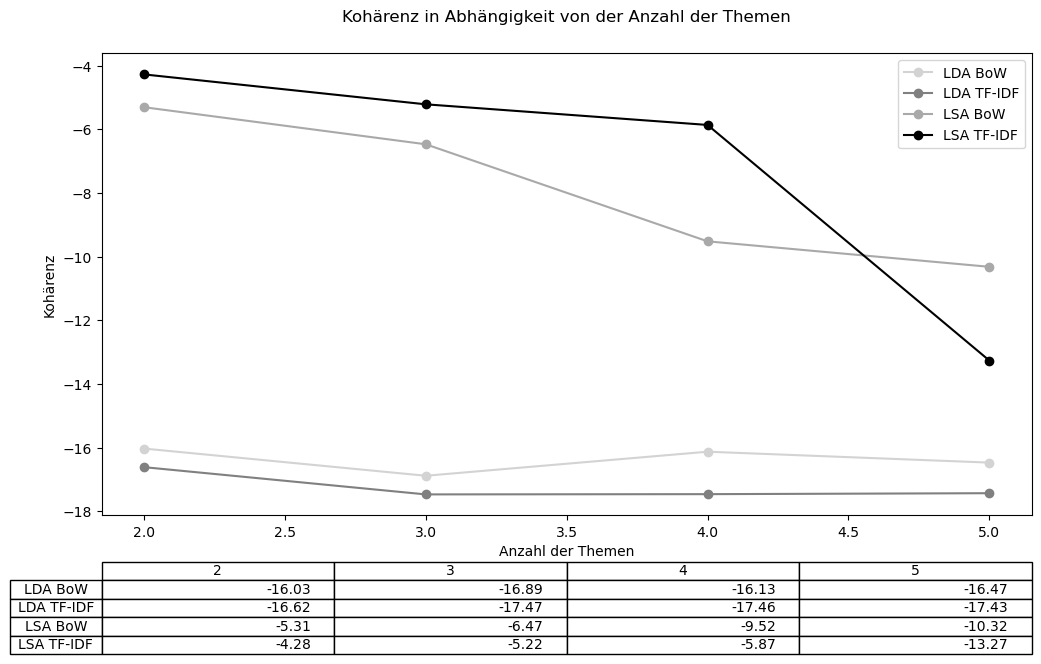

In [11]:
plot_coherence(coherence_values=coherence, no_topics=no_topics)

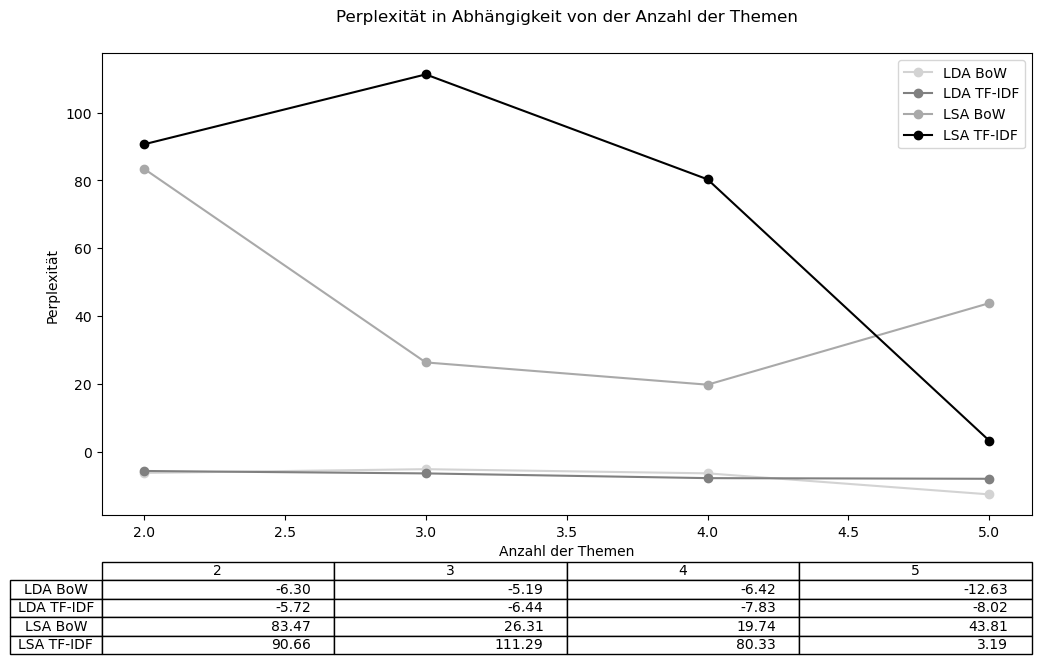

In [12]:
plot_perplexity(perplexity_values=perplexity, no_topics=no_topics)

# Visualisiere die Modelle

In [13]:
# Trainiere das Word2Vec Model
word2vec_model = Word2Vec(sentences=data_ready, vector_size=300, window=2, min_count=1, workers=8)
#word2vec_model.save("word2vec_model")
#word2vec_model = Word2Vec.load("word2vec_model")

In [14]:
def coherence_per_topic(model, texts, dictionary, model_name):
    # Berechne die Kohärenz pro Thema
    coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence_per_topic = coherence_model.get_coherence_per_topic()
    
    # Extrahiere die Wörter und Vektoren für jedes Thema (hier nur 5 Terme)
    topic_words_embeddings = []
    for topic in range(model.num_topics):
        topic_words = [word for word, _ in model.show_topic(topic, topn=5)]
        
        # Filtere Wörter, die im Word2Vec-Modell vorhanden sind
        valid_words = [word for word in topic_words if word in word2vec_model.wv]

        if valid_words:
            # Berechne den durchschnittlichen Vektor für das Thema
            topic_embedding = sum(word2vec_model.wv[word] for word in valid_words) / len(valid_words)
            topic_words_embeddings.append((topic_words, topic_embedding))
        else:
            topic_words_embeddings.append((topic_words, None))

    # Erstelle ein DataFrame
    topics_str = ['\n'.join(words) for words, _ in topic_words_embeddings]
    topic_score = pd.DataFrame(data=zip(topics_str, coherence_per_topic), columns=['Themen', 'Kohärenz'])
    topic_score = topic_score.set_index('Themen')

    # Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    
    ax.set_title(f"Themenkohärenz für {str(model)}\n")
    
    sns.heatmap(data=topic_score, annot=True, square=False,
                cmap='gray', fmt='.2f', linewidths=1,
                linecolor='black', vmin=0, vmax=-18, ax=ax)
    
    plt.yticks(rotation=0)
    
    plt.savefig(f'Themenkohaerenz_{model_name}.png', bbox_inches='tight', dpi=150)
    
    plt.show()

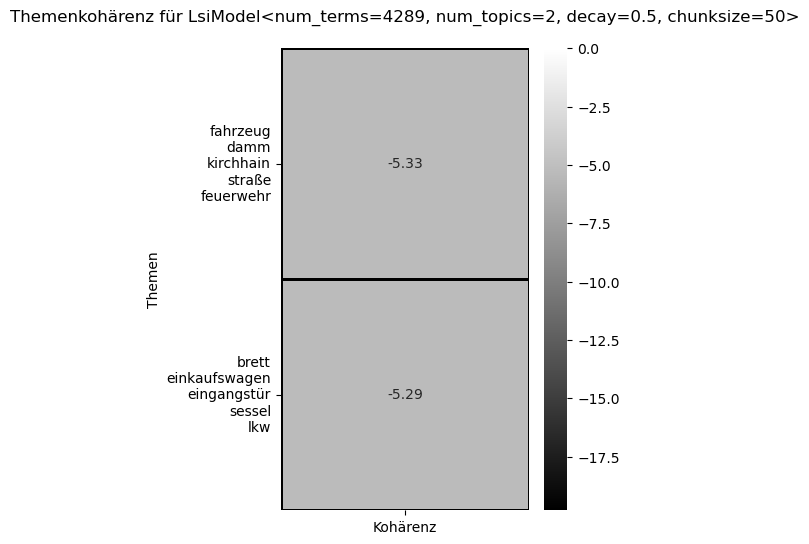

In [15]:
coherence_per_topic(model=best_model_lsa_bow, texts=data_ready, dictionary=id2word, model_name="LSA_BOW")

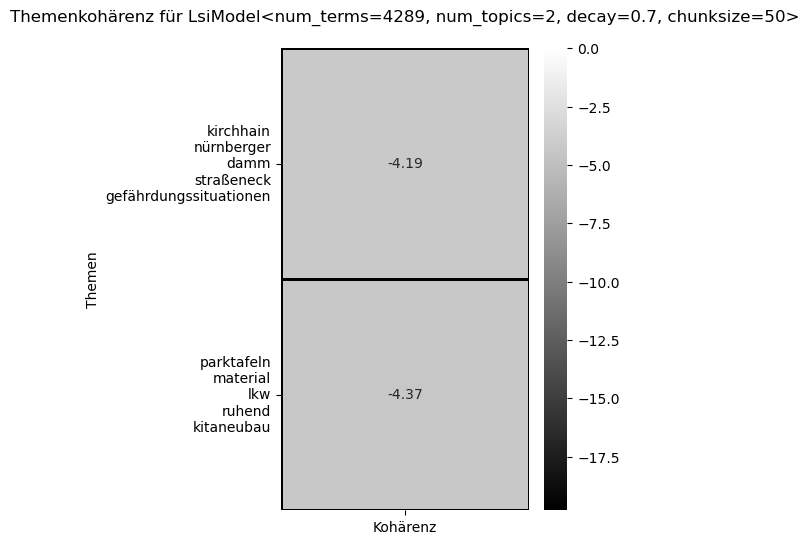

In [16]:
coherence_per_topic(model=best_model_lsa_tfidf, texts=data_ready, dictionary=id2word, model_name='LSA_TFIDF')

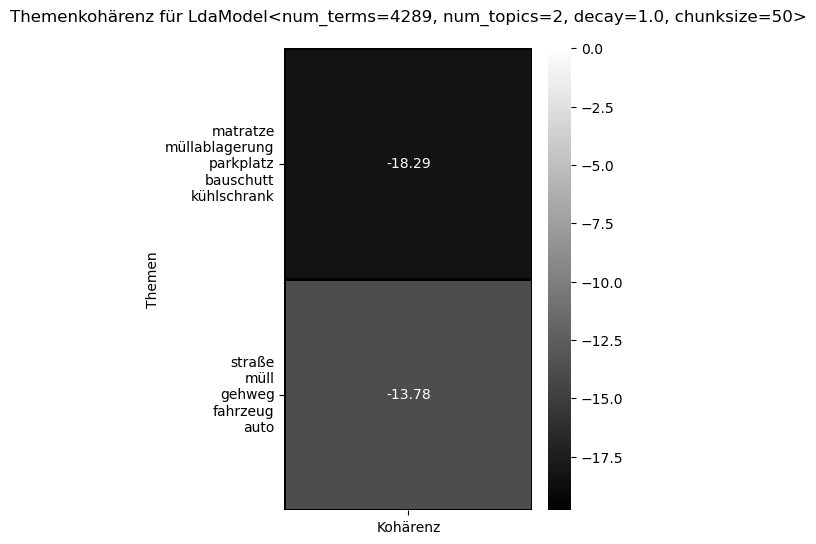

In [17]:
coherence_per_topic(model=best_model_lda_bow, texts=data_ready, dictionary=id2word, model_name='LDA_BoW')

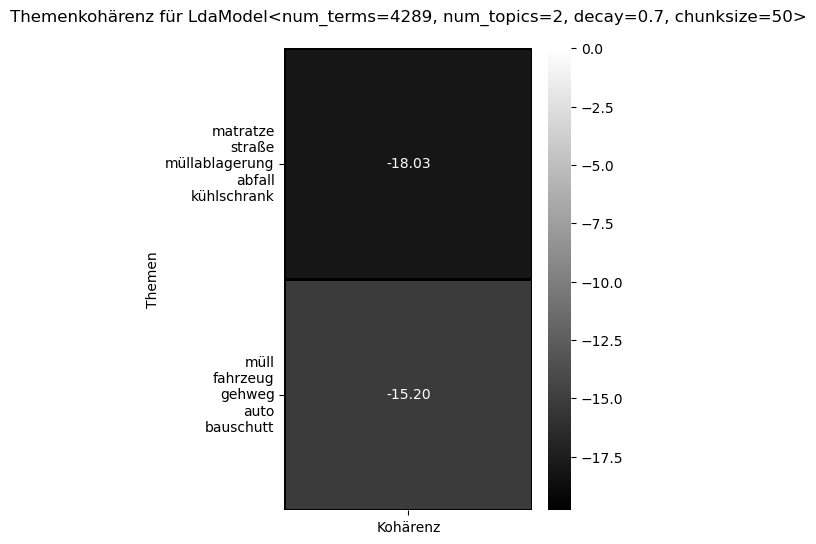

In [18]:
coherence_per_topic(model=best_model_lda_tfidf, texts=data_ready, dictionary=id2word, model_name='LDA_TFIDF')

In [19]:
def plot_topic_distribution(model, corpus, word2vec_model, model_name):
    dominant_topics = []
    topic_percentages = []
    
    # Entpacke Werte aus dem Ergebnis basierend auf dem Modelltyp
    if isinstance(model, models.LdaModel):
        # Iteriere durch jedes Dokument im Korpus
        for idx, row in enumerate(corpus):
            topic_weights = model[row]
            dominant_topic = sorted(topic_weights, key = lambda x: x[1], reverse=True)[0][0]
            dominant_topics.append((idx, dominant_topic))
            topic_percentages.append(topic_weights)

    elif isinstance(model, models.LsiModel):
        # Iteriere durch jedes Dokument im Korpus
        for idx, row in enumerate(corpus):
            # Rufe die Ergebnisse des Modells für das aktuelle Dokument ab
            result = model[row]

            # Entpacke die Werte
            topic_num, topic_weights = zip(*result) if result else ([], [])
            
            # Filtere negative Gewichte aus
            non_negative_weights = [(idx, weight) for idx, weight in enumerate(topic_weights) if weight >= 0]

            # Sortiere nach Gewicht und erhalte das dominante Thema
            if non_negative_weights:
                dominant_topic = sorted(non_negative_weights, key=lambda x: x[1], reverse=True)[0][0]
                dominant_topics.append((idx, dominant_topic))
                topic_percentages.append(non_negative_weights)

    # Verteilung der dominanten Themen in jedem Dokument
    df_dominant_topic = pd.DataFrame(dominant_topics, columns=['Document_ID', 'Dominant_Topic'])
    dominant_topic_counts = df_dominant_topic.groupby('Dominant_Topic').size().reset_index(name='count')

    # Gesamtthemenverteilung nach tatsächlichem Gewicht
    topic_weight = pd.DataFrame([dict(t) for t in topic_percentages])
    df_topic_weight = topic_weight.sum().reset_index(name='count')

    # Sortiere dominant_topic_counts und df_topic_weight nach Thema
    dominant_topic_counts = dominant_topic_counts.sort_values('Dominant_Topic')
    df_topic_weight = df_topic_weight.sort_values('index')
    
    # Top-Schlüsselwörter für jedes Thema mit Word Embeddings
    topic_top_words_with_embeddings = []

    for idx, topics in model.show_topics(formatted=False):
        # Extrahiere die Top-Wörter für jedes Thema
        topic_words = [word for word, _ in topics]

        # Extrahiere die Word Embeddings für jedes Top-Wort
        embeddings = [word2vec_model.wv[word] for word in topic_words if word in word2vec_model.wv]

        # Berechne den Durchschnitt der Word Embeddings für jedes Thema
        topic_embedding = sum(embeddings) / len(embeddings) if embeddings else None

        # Extrahiere die relevanten Wörter basierend auf den Word Embeddings
        relevant_words = [word for word, _ in word2vec_model.wv.similar_by_vector(topic_embedding, topn=5)]

        # Füge die Ergebnisse zur Liste hinzu
        topic_top_words_with_embeddings.append((idx, relevant_words))

    # Erstelle ein DataFrame aus den Ergebnissen
    df_top_words = pd.DataFrame(topic_top_words_with_embeddings, columns=['topic_id', 'words'])
    df_top_words = df_top_words.groupby('topic_id')['words'].apply(lambda x: ',\n'.join(',\n'.join(sublist) for sublist in x)).reset_index()
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150, sharey=True)
    
    # Abstand zwischen den Subplots anpassen
    plt.subplots_adjust(wspace=0.1)
    
    # Verteilung der dominanten Themen
    ax1.bar(x='Dominant_Topic', height='count', data=dominant_topic_counts, width=.5, color='gray')
    ax1.set_xticks(range(dominant_topic_counts.Dominant_Topic.nunique()))
    
    # Beschriftungen und Titel setzen
    for i, count in enumerate(dominant_topic_counts['count']):
        ax1.text(i, count, str(count), ha='center', va='bottom', fontsize=10, color='black')
    
    formatter = FuncFormatter(lambda x, pos: 'Thema ' + str(x + 1) + '\n' + df_top_words.loc[df_top_words.topic_id == x, 'words'].values[0])
    ax1.xaxis.set_major_formatter(formatter)
    ax1.set_title(f'Anzahl der Dokumente nach vorherrschendem Thema für \n{model}', fontdict=dict(size=10))
    ax1.set_ylabel('Anzahl der Dokumente')
    
    # Dynamische Anpassung der y-Achse
    max_count = dominant_topic_counts['count'].max()
    ax1.set_ylim(0, max_count + 500)

    # Verteilung der Themen nach Gewicht
    ax2.bar(x='index', height='count', data=df_topic_weight, width=.5, color='darkgray')
    ax2.set_xticks(range(df_topic_weight.index.nunique()))
    
    # Beschriftungen und Titel setzen
    for i, count in enumerate(df_topic_weight['count']):
        ax2.text(i, count, str(round(count, 2)), ha='center', va='bottom', fontsize=10, color='black')
        
    ax2.xaxis.set_major_formatter(formatter)
    ax2.set_title(f'Anzahl der Dokumente nach Themengewichtung für \n{model}', fontdict=dict(size=10))
    
    # Schriftgröße der x-Achsentexte
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10)
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=10)
    
    plt.savefig(f'Themenverteilung_{model_name}.png', bbox_inches='tight', dpi=150)
    
    plt.show()


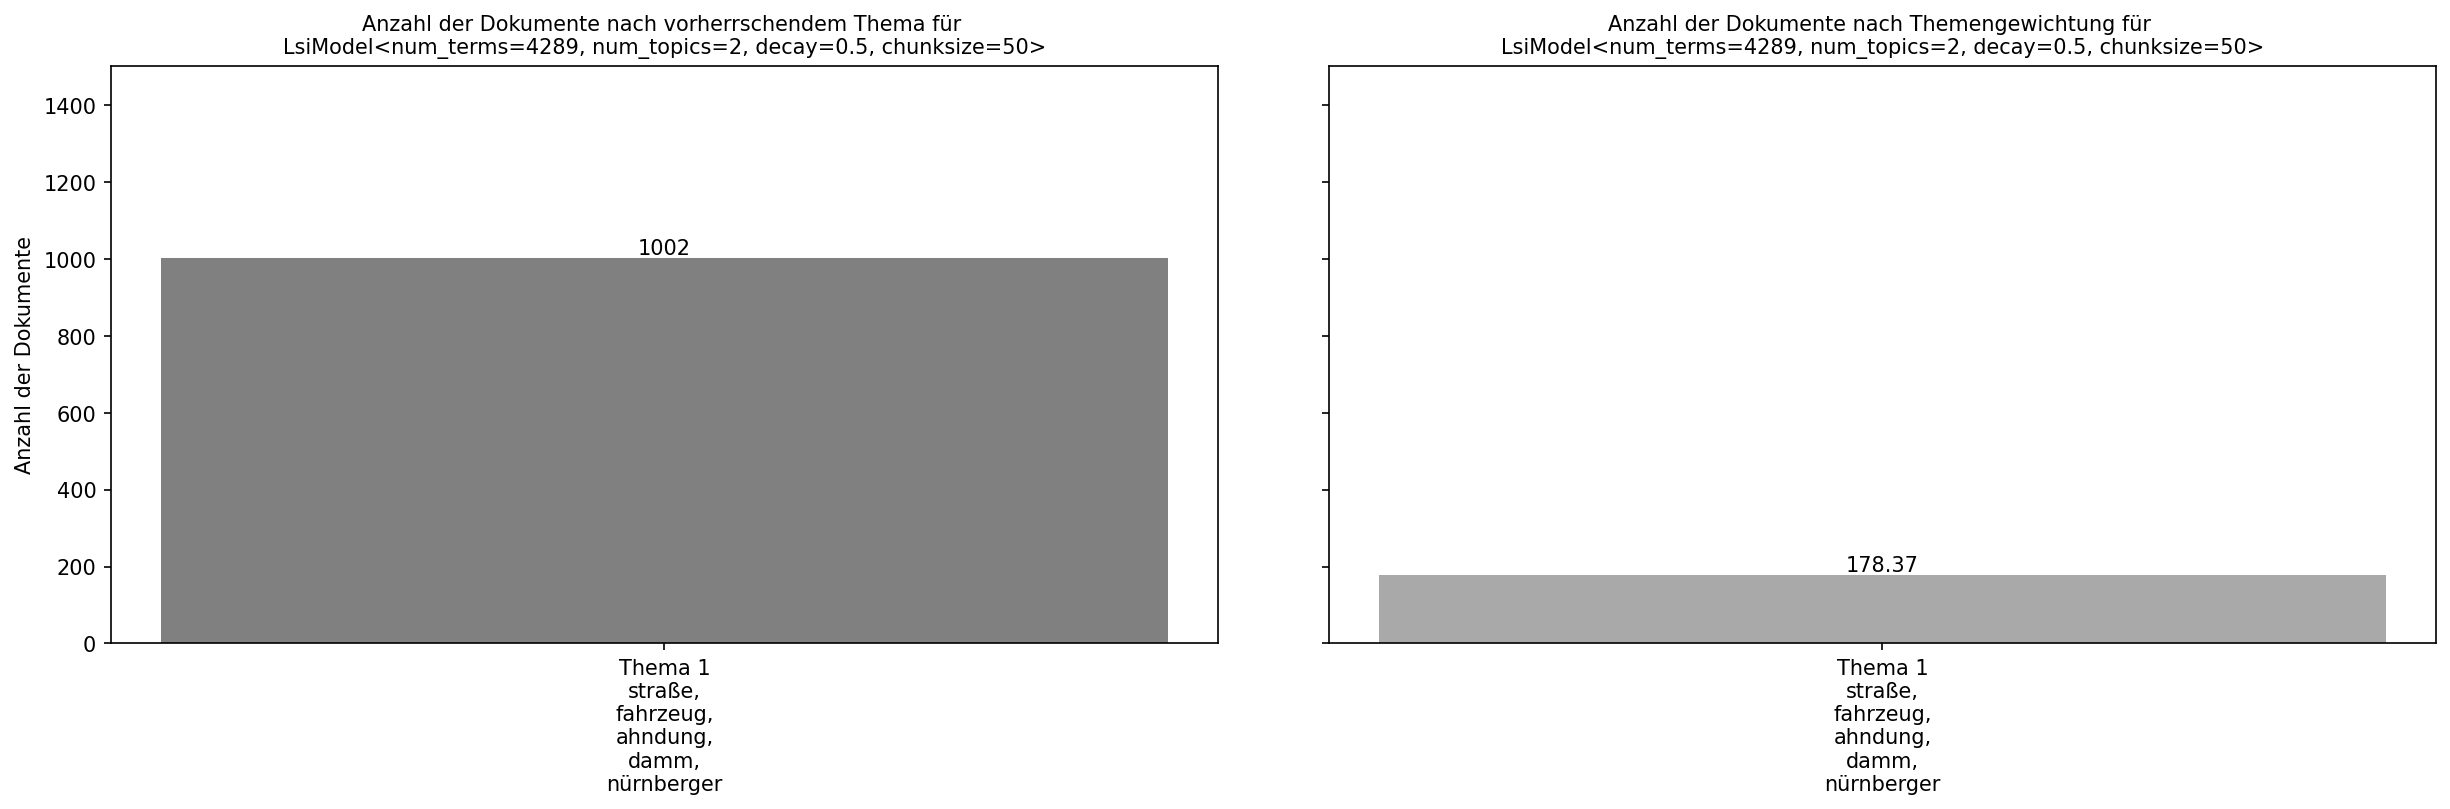

In [20]:
plot_topic_distribution(model=best_model_lsa_bow, corpus=bow_corpus, word2vec_model=word2vec_model, model_name='LSA_BoW')

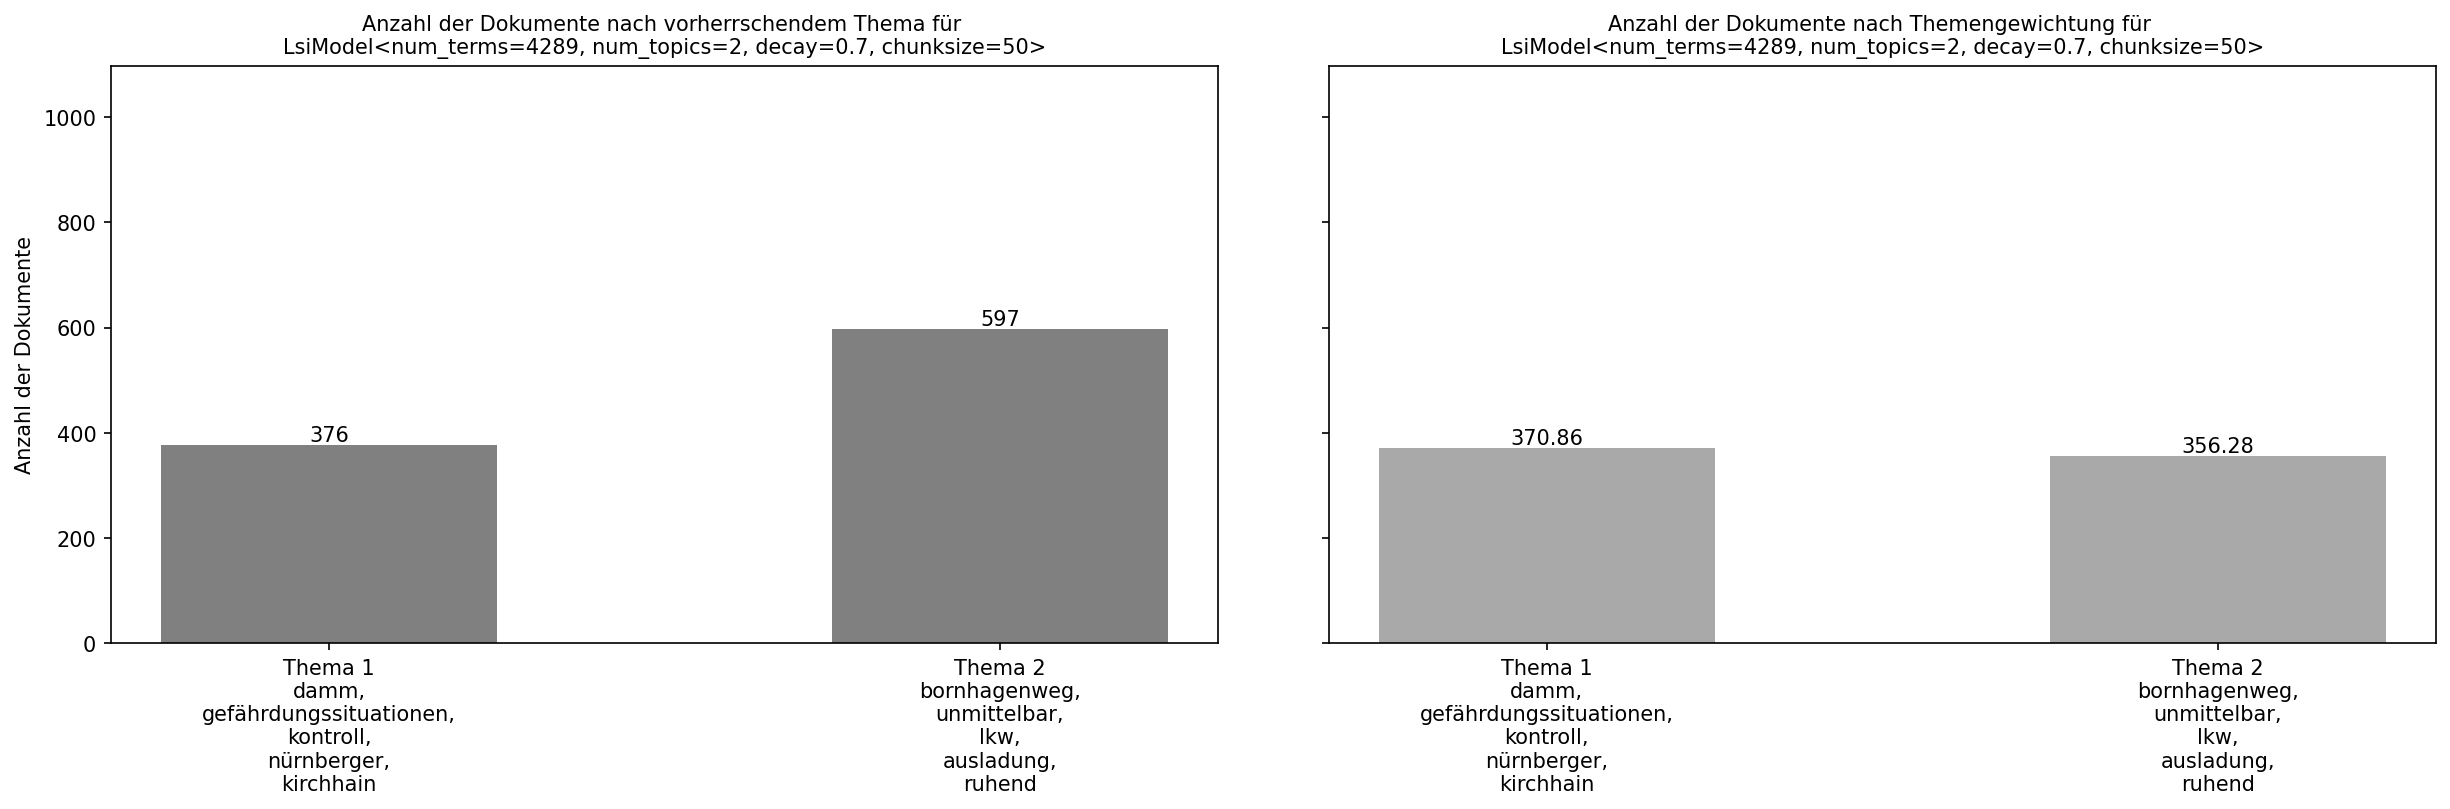

In [21]:
plot_topic_distribution(model=best_model_lsa_tfidf, corpus=corpus_lsa_tfidf, word2vec_model=word2vec_model, model_name='LSA_TFIDF')

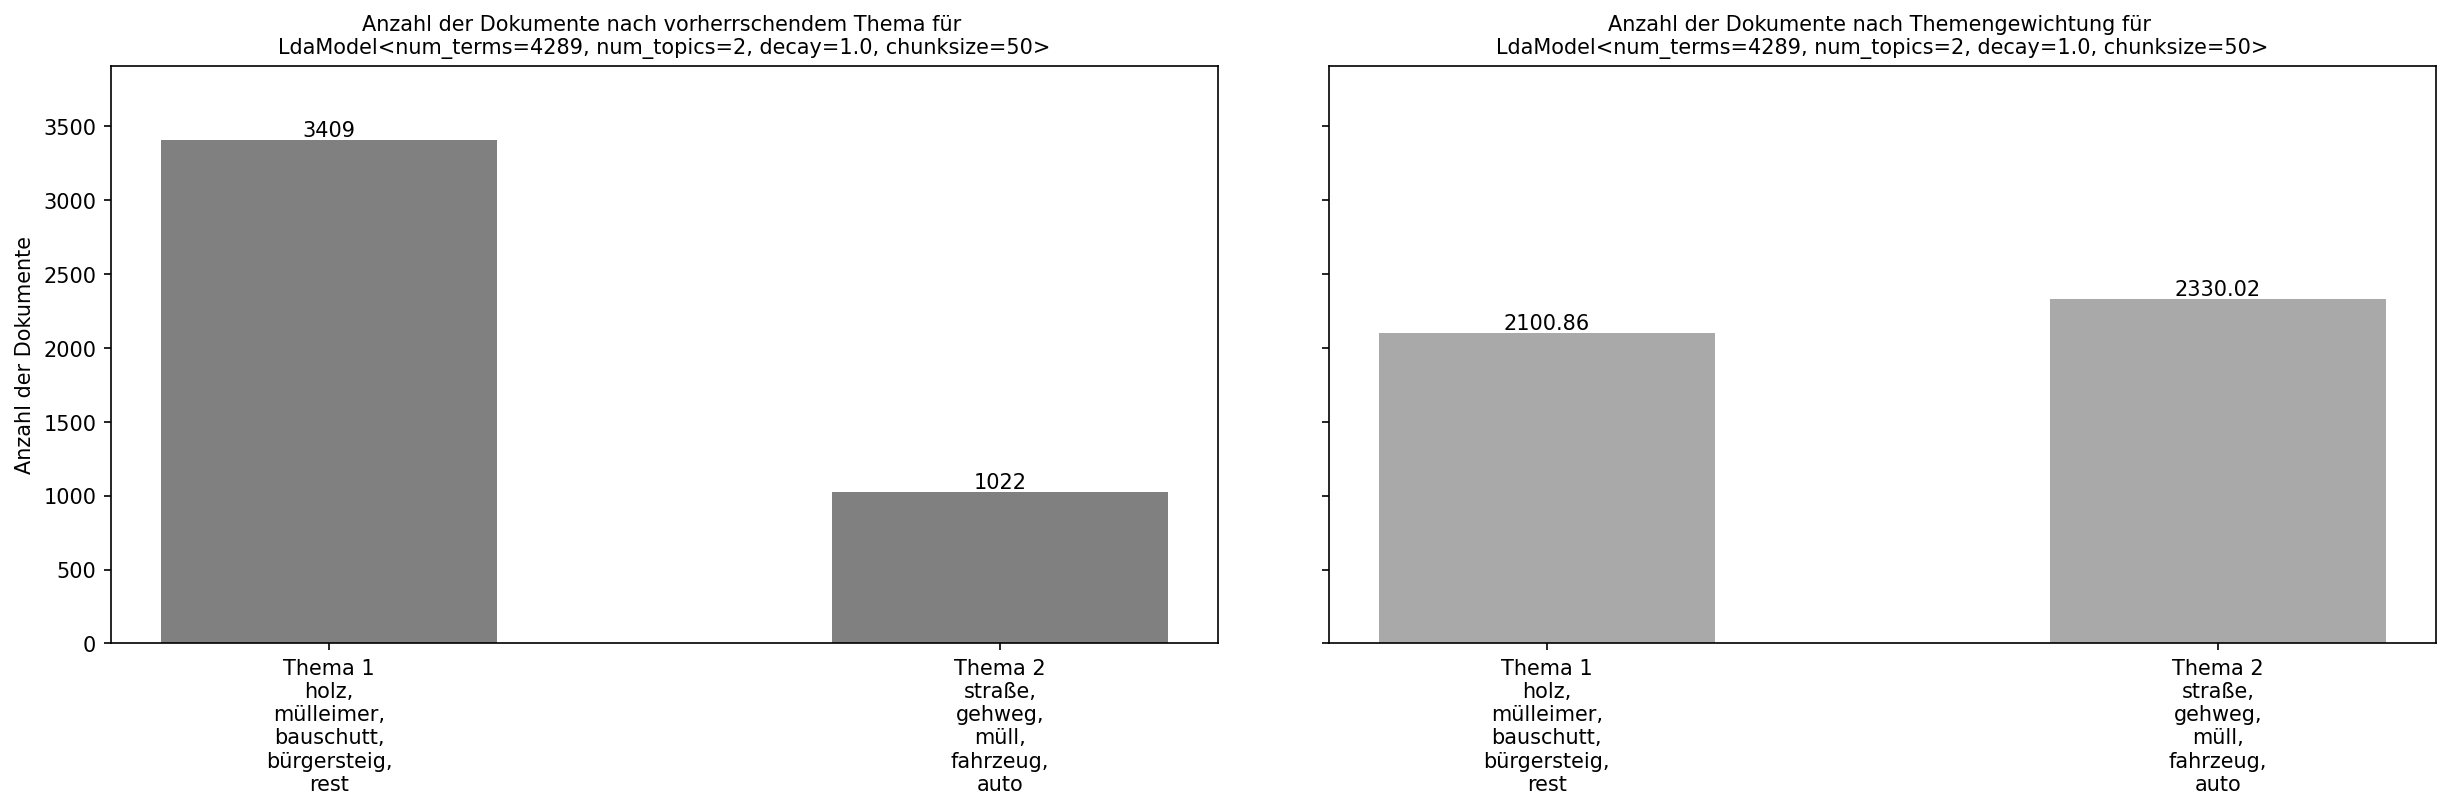

In [22]:
plot_topic_distribution(model=best_model_lda_bow, corpus=bow_corpus, word2vec_model=word2vec_model, model_name='LDA_BoW')

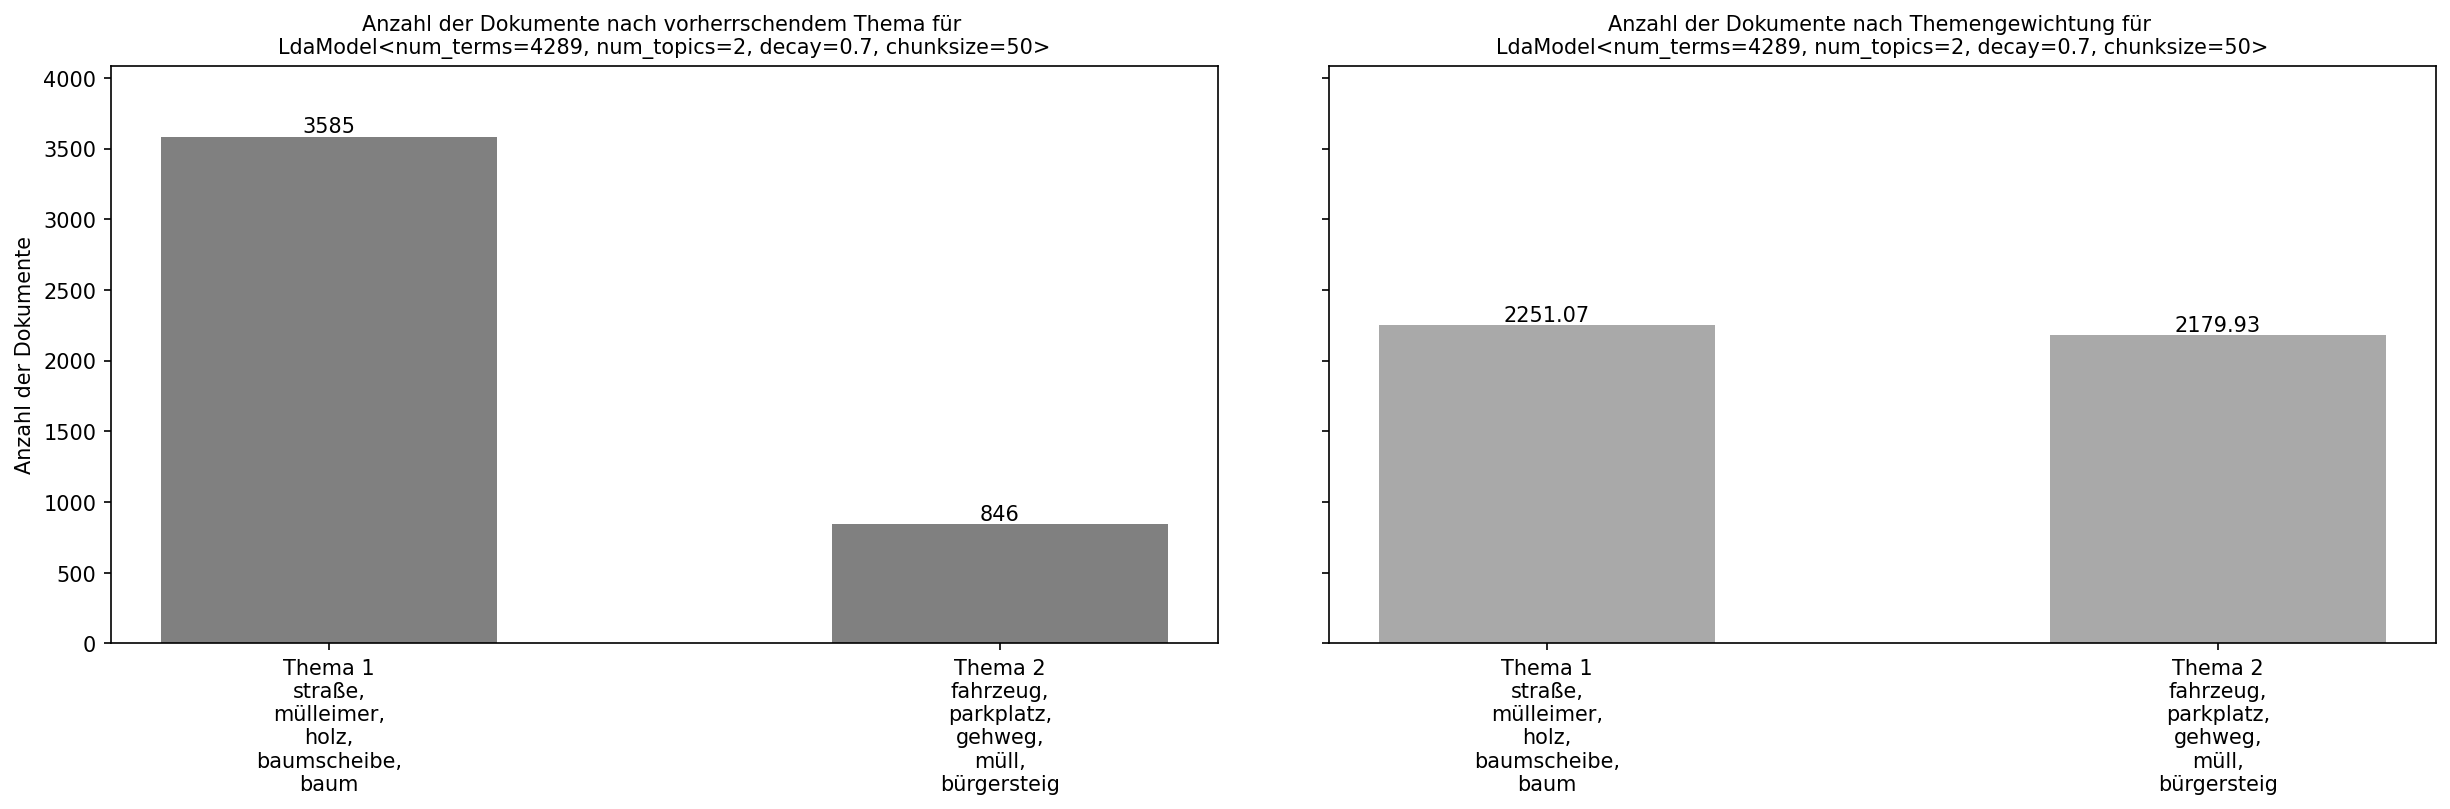

In [23]:
plot_topic_distribution(model=best_model_lda_tfidf, corpus=corpus_lda_tfidf, word2vec_model=word2vec_model, model_name='LDA_TFIDF')

In [24]:
# Visualisierung der Themen für LDA mit pyLDAvis, hier LDA BoW
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model_lda_bow, bow_corpus, dictionary=best_model_lda_bow.id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.314336  0.0       1        1  57.740459
0     -0.314336  0.0       2        1  42.259541, topic_info=               Term         Freq        Total Category  logprob  loglift
38           straße  1569.000000  1569.000000  Default  30.0000  30.0000
63         matratze   829.000000   829.000000  Default  29.0000  29.0000
29   müllablagerung   547.000000   547.000000  Default  28.0000  28.0000
10           gehweg   785.000000   785.000000  Default  27.0000  27.0000
7          fahrzeug   650.000000   650.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
59  toilettenbecken    26.513472    26.549515   Topic2  -5.3261   0.8600
57           asbest    24.408100    24.444142   Topic2  -5.4088   0.8599
25        dämmwolle    23.783197    23.819239   Topic2  -5.4347   0.8598
36             müll   142.364020  1063.375455   Topic2  -3.6453  -1.1495
3               uhr    48.948676   279.340604   Topic2  -4.7129  -0.8803

[94 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
32        1  0.999327               abfall
39        2  1.004319  altkleidercontainer
4         1  1.001587                ampel
57        2  0.981830               asbest
13        1  0.999308                 auto
...     ...       ...                  ...
3         1  0.823368                  uhr
3         2  0.175413                  uhr
44        2  0.998936             umgebung
19        1  1.012274                wiese
27        2  1.003498             übervoll

[64 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [25]:
def plot_kmeans_clustering(model, word2vec_model, model_name):
    
    # Erstelle die Matrix der Wortvektoren im word2vec_model
    word_vectors = word2vec_model.wv.vectors
    # Verwende TSNE zur Reduzierung der Dimensionen auf 2D
    tsne = TSNE(n_components=2, random_state=42)
    # Erstelle die 2D-Repräsentation der Wortvektoren
    reduced_word_vectors = tsne.fit_transform(word_vectors)
    
    # Bestimme die Anzahl der Cluster basierend auf der Anzahl der Topics im LDA-Modell
    num_clusters = model.num_topics
    # Wende K-Means-Clustering auf die 2D-reduzierten Vektoren an
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    kmeans.fit(reduced_word_vectors)

    # Hole die Cluster-Zuordnungen für jedes Wort
    word_clusters = kmeans.labels_
    # Hole die Wörter aus dem Word2Vec-Modell
    words = list(word2vec_model.wv.index_to_key)
    # Extrahiere die Wörter, die den reduzierten Wortvektoren entsprechen
    words_for_points = [words[i] for i in range(len(reduced_word_vectors))]
    
    # Generiere den Plot
    hover_text = [f'Word: {word}<br>Cluster: {cluster + 1}' for word, cluster in zip(words, word_clusters)]
    
    scatter_trace = go.Scatter(
        x=reduced_word_vectors[:, 0],
        y=reduced_word_vectors[:, 1],
        mode='markers',
        text=words,
        hovertext=hover_text,  # Verwende hover_text für detaillierte Informationen
        textposition='top center',
        marker=dict(
            size=8,
            color=word_clusters,
            colorscale='Gray',
            opacity=0.8
        ),
        name='Cluster',
    )
    
    layout = go.Layout(
        title=f'2D Wort Embeddings mit K-means Clustering für {model}',
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        legend_title='Clusters',
        hovermode='closest'
    )
    
    fig = go.Figure(data=[scatter_trace], layout=layout)
    
    fig.write_image(f'KMeans_Clustering_{model_name}.png', engine="kaleido") 
    
    fig.show()

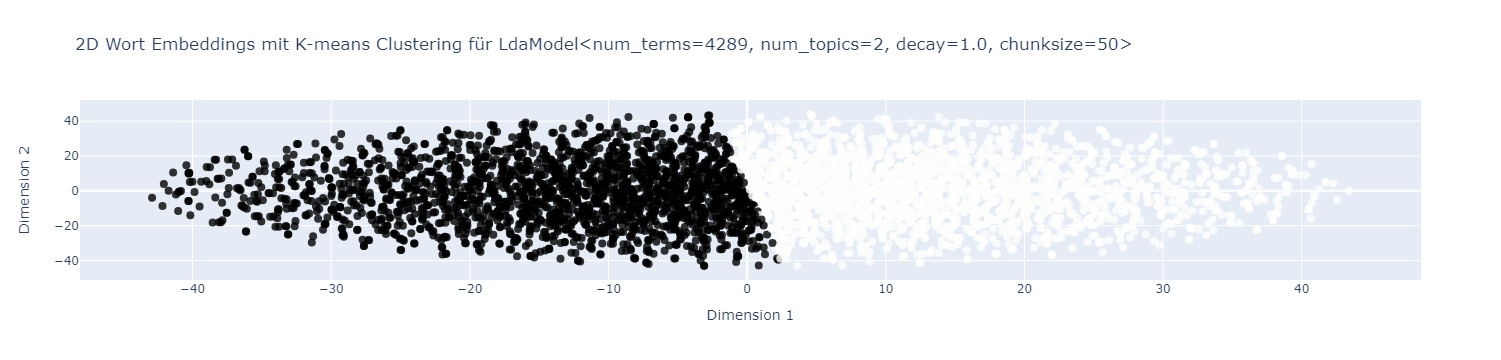

In [26]:
plot_kmeans_clustering(model=best_model_lda_bow, word2vec_model=word2vec_model, model_name='LDA_BoW')

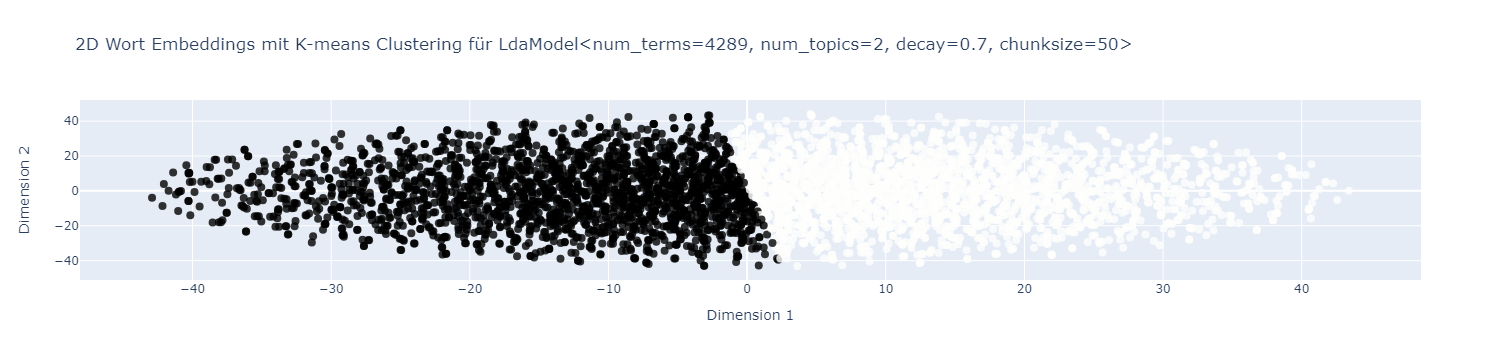

In [27]:
plot_kmeans_clustering(model=best_model_lda_tfidf, word2vec_model=word2vec_model, model_name='LDA_TFIDF')

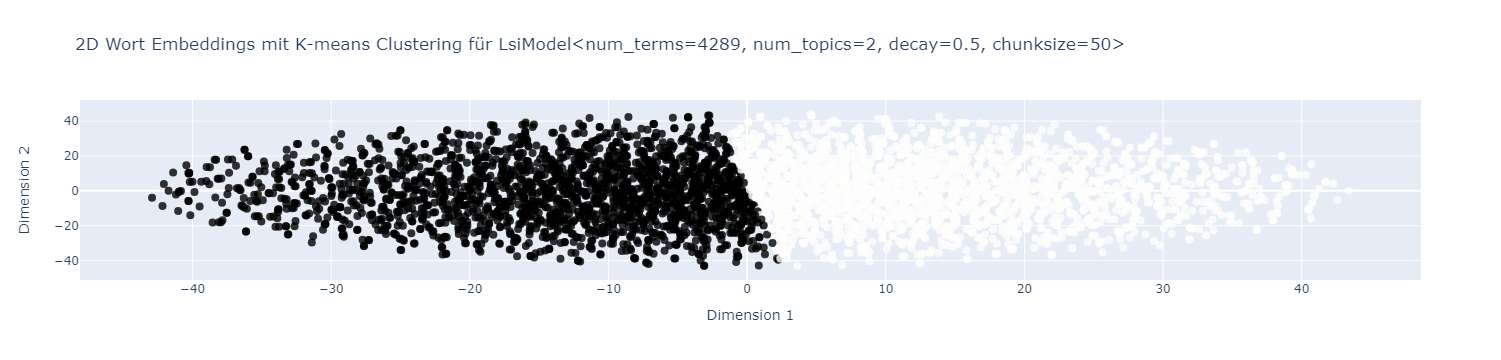

In [28]:
plot_kmeans_clustering(model=best_model_lsa_bow, word2vec_model=word2vec_model, model_name='LSA_BoW')

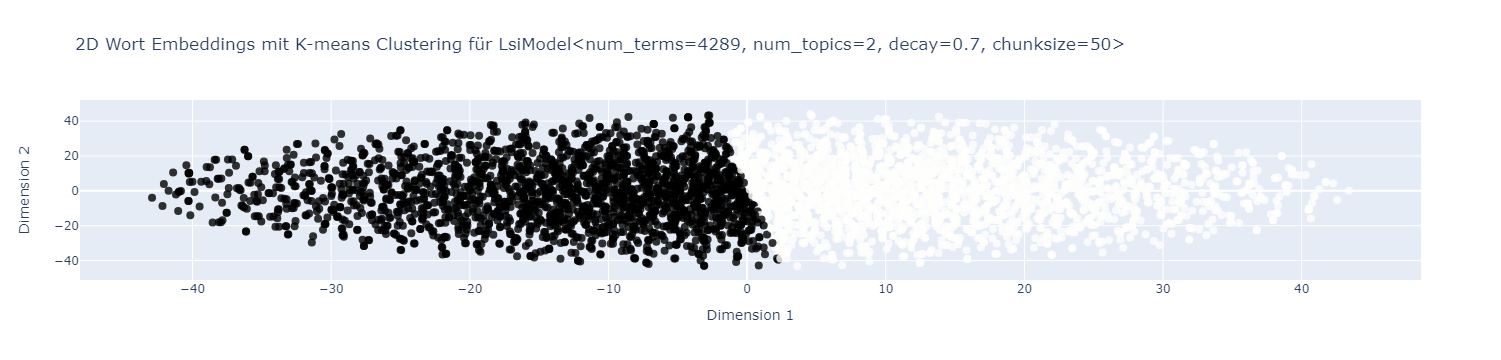

In [29]:
plot_kmeans_clustering(model=best_model_lsa_tfidf, word2vec_model=word2vec_model, model_name='LSA_TFIDF')